Steps:
1. User-level aggregatio table
2. Plot late rate vs. borrowing count
3. Compare early vs. later borrowings. learning vs. overload
4. Interpret

borrowing intensity bins
learning effecgt plot

In [233]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cycler import cycler

plt.rcParams["axes.prop_cycle"] = cycler(color=["#a51e36"])

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")


In [234]:
# --- load data ---
PROCESSED_DATA_PATH = Path('../data/processed')
DATA_FILE = PROCESSED_DATA_PATH / "borrowings_2019_2025_cleaned.csv"

borrowings = pd.read_csv(
    DATA_FILE,
    sep=";",
    quotechar='"',
    encoding="utf-8"
)

print("Loaded shape:", borrowings.shape)

Loaded shape: (2357146, 18)


In [235]:
# --- preprocess relevant columns ---

# column names
ISSUE_COL = "Ausleihdatum/Uhrzeit"

USER_ID_COL = "Benutzer-Systemnummer"
USER_CATEGORY_COL = "Benutzerkategorie"

LATE_FLAG_COL = "Verspätet"

# normalize late flag to boolean (Ja/Nein -> True/False); keep unknown as <NA>
if LATE_FLAG_COL in borrowings.columns:
    v = borrowings[LATE_FLAG_COL].astype(str).str.strip().str.lower()
    borrowings["late_bool"] = pd.Series(np.where(v == "ja", True, np.where(v == "nein", False, pd.NA)), dtype="boolean")



In [236]:
# --- aggregate user-level statistics ---
borrowings_user = borrowings[borrowings[USER_ID_COL].notna()].copy()

user_df = (
    borrowings_user
    .groupby(USER_ID_COL)
    .agg(
        n_borrowings=("issue_id", "count"),
        late_rate=("late_bool", "mean"),
        n_late=("late_bool", "sum"),
        avg_duration=("Leihdauer", "mean"),
        max_duration=("Leihdauer", "max"),
        avg_extensions=("Anzahl_Verlängerungen", "mean"),
        max_extensions=("Anzahl_Verlängerungen", "max"),
        user_category=(USER_CATEGORY_COL, "first"),
    )
    .reset_index()
)

user_df.head()


,Benutzer-Systemnummer,n_borrowings,late_rate,n_late,avg_duration,max_duration,avg_extensions,max_extensions,user_category
0,1.0000,7,0.0000,0,0.0000,0.0000,0.0000,0,SYS
1,25.0000,365,0.0027,1,61.9671,356.0000,1.2685,7,MDA
2,26.0000,1520,0.0020,3,13.2901,296.0000,0.1954,11,MDA
3,27.0000,2700,0.0004,1,13.2111,359.0000,0.0704,6,MDA
4,28.0000,764,0.0052,4,10.4241,351.0000,0.1505,9,MDA


In [237]:
user_df["n_borrowings"].describe()

count   21,161.0000
mean       103.6831
std        206.4430
min          1.0000
25%          8.0000
50%         29.0000
75%        109.0000
max      6,154.0000
Name: n_borrowings, dtype: float64

In [238]:
#-- filter user-level table for special cases ---

user_df = user_df[user_df["user_category"] != "SYS"].copy()
user_df = user_df[user_df["user_category"] != "MDA"].copy()

user_df = user_df[
    (user_df["n_borrowings"] >= 1) &
    (user_df["n_borrowings"] <= 500)
].copy()

user_df["n_borrowings"].describe()

count   20,231.0000
mean        71.1649
std        100.3526
min          1.0000
25%          7.0000
50%         27.0000
75%         92.0000
max        500.0000
Name: n_borrowings, dtype: float64

## Late Return vs. Number of loans per user

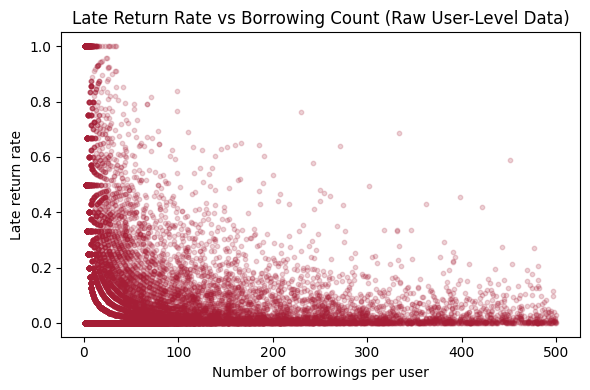

In [239]:
# --- analyze late return rate by borrowing intensity ---

plt.figure(figsize=(6, 4))
plt.scatter(
    user_df["n_borrowings"],
    user_df["late_rate"],
    alpha=0.2,
    s=10
)
plt.xlabel("Number of borrowings per user")
plt.ylabel("Late return rate")
plt.title("Late Return Rate vs Borrowing Count (Raw User-Level Data)")
plt.tight_layout()
plt.show()


As expected, the raw user-level relationship between borrowing frequency and late return rates is highly noisy for users with few borrowings, reflecting small-sample variability. The variance decreases substantially with increasing borrowing count, motivating aggregation into borrowing-frequency bins to reveal systematic trends.


/var/folders/zc/502jnxhs5bx_38b0r7xb68xm0000gn/T/ipykernel_87406/3938599108.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("borrowing_bin")


,mean_late_rate,n_users
borrowing_bin,,
1–5,0.1366,3170
6–10,0.1141,2158
11–20,0.0981,2619
21–50,0.0877,3717
51–100,0.0685,2736
101–200,0.0568,2468
201–500,0.0390,2232


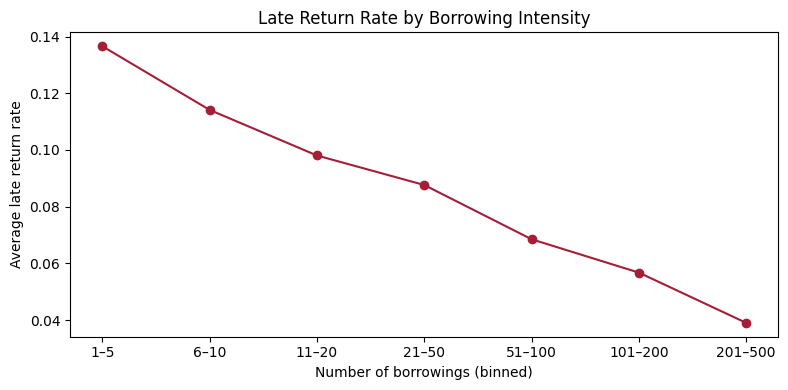

In [240]:
# --- analyze late return rate by borrowing intensity ---

# work on the filtered user-level table
df_u = user_df.copy()

# define borrowing-intensity bins
bins = [1, 5, 10, 20, 50, 100, 200, 500]
labels = ["1–5", "6–10", "11–20", "21–50", "51–100", "101–200", "201–500"]

df_u["borrowing_bin"] = pd.cut(
    df_u["n_borrowings"],
    bins=bins,
    labels=labels,
    right=True
)

# aggregate late rate per bin
bin_summary = (
    df_u
    .groupby("borrowing_bin")
    .agg(
        mean_late_rate=("late_rate", "mean"),
        n_users=("late_rate", "count")
    )
)

display(bin_summary)

# plot
plt.figure(figsize=(8, 4))
plt.plot(
    bin_summary.index.astype(str),
    bin_summary["mean_late_rate"],
    marker="o"
)
plt.xlabel("Number of borrowings (binned)")
plt.ylabel("Average late return rate")
plt.title("Late Return Rate by Borrowing Intensity")
plt.tight_layout()
plt.show()


The plot shows a clear and monotonic decrease in late return rates with increasing borrowing intensity. Users with few borrowings exhibit the highest late rates, while frequent borrowers are substantially less likely to return items late. This pattern is consistent with a learning or experience effect: as users borrow more often, they appear to manage loan deadlines more reliably. The smooth trend across bins suggests that this relationship reflects systematic behavioral differences rather than random noise.

# Learning over Time within Users

Do users become more reliable over the course of their borrowing history?

Previous analyses revealed that frequent borrowers exhibit substantially lower late return rates than occasional users. While this pattern is robust, it does not yet explain *why* it occurs. In particular, lower lateness among frequent users may arise from different underlying mechanisms, such as learning, adaptation to library rules, or accumulated experience in managing loan deadlines.

To disentangle these explanations, it is necessary to move beyond cross-sectional comparisons and examine how late return behavior evolves *within individual users* over the course of their borrowing history. By analyzing changes in lateness across successive borrowings for the same users, we can assess whether reliability improves with experience or whether observed differences are driven by structural or selection effects.


In [241]:
# --- analyze learning effect over time ---

borrowings[ISSUE_COL] = pd.to_datetime(borrowings[ISSUE_COL], errors="coerce")

df_learning = borrowings[borrowings[USER_ID_COL].notna()].copy()

# sort by user and time
df_learning = df_learning.sort_values([USER_ID_COL, ISSUE_COL])

# assign borrowing order per user
df_learning["borrow_index"] = (
    df_learning
    .groupby(USER_ID_COL)
    .cumcount() + 1
)

df_learning[[USER_ID_COL, ISSUE_COL, "borrow_index"]].head(10)


,Benutzer-Systemnummer,Ausleihdatum/Uhrzeit,borrow_index
72,1.0000,2019-01-17 14:11:33,1
73,1.0000,2019-01-17 14:15:12,2
131916,1.0000,2019-05-17 12:00:34,3
192900,1.0000,2019-07-12 09:36:38,4
192901,1.0000,2019-07-12 09:37:03,5
1168352,1.0000,2022-08-12 10:34:03,6
1168353,1.0000,2022-08-12 10:36:24,7
282926,25.0000,2019-09-25 11:47:34,1
282927,25.0000,2019-09-25 11:47:36,2
282928,25.0000,2019-09-25 11:47:37,3


In [242]:
EXPERIENCE_CUTOFF = 5

df_learning["experience_stage"] = np.where(
    df_learning["borrow_index"] <= EXPERIENCE_CUTOFF,
    "early",
    "experienced"
)

df_learning["experience_stage"].value_counts()


experience_stage
experienced    2098111
early            95928
Name: count, dtype: int64

In [243]:
stage_late_rate = (
    df_learning
    .groupby("experience_stage")["late_bool"]
    .mean()
)

stage_late_rate

experience_stage
early         0.0764
experienced   0.0410
Name: late_bool, dtype: Float64

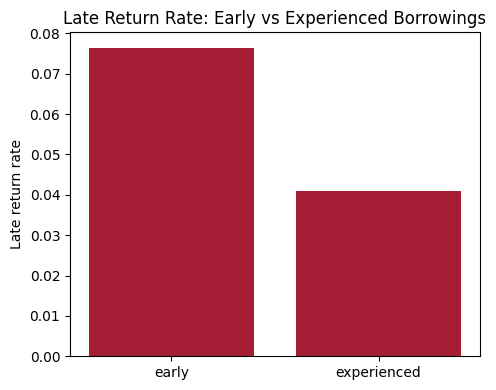

In [244]:
# -- plot late rate by experience stage ---

plt.figure(figsize=(5, 4))
plt.bar(stage_late_rate.index, stage_late_rate.values)
plt.ylabel("Late return rate")
plt.title("Late Return Rate: Early vs Experienced Borrowings")
plt.tight_layout()
plt.show()

The late return rate is substantially higher for early borrowings than for later borrowings of the same users. This decline provides strong evidence of a learning or adaptation effect, whereby users become more reliable as they gain borrowing experience.


## Larning curves

In [245]:
MAX_BORROWING_INDEX = 500

df_curve = df_learning[df_learning["borrow_index"] <= MAX_BORROWING_INDEX].copy()

learning_curve = (
    df_curve
    .groupby("borrow_index")["late_bool"]
    .agg(
        late_rate="mean",
        n_obs="count"
    )
    .reset_index()
)

learning_curve.head()


,borrow_index,late_rate,n_obs
0,1,0.0849,21161
1,2,0.0777,20030
2,3,0.0749,19048
3,4,0.0720,18214
4,5,0.0710,17475


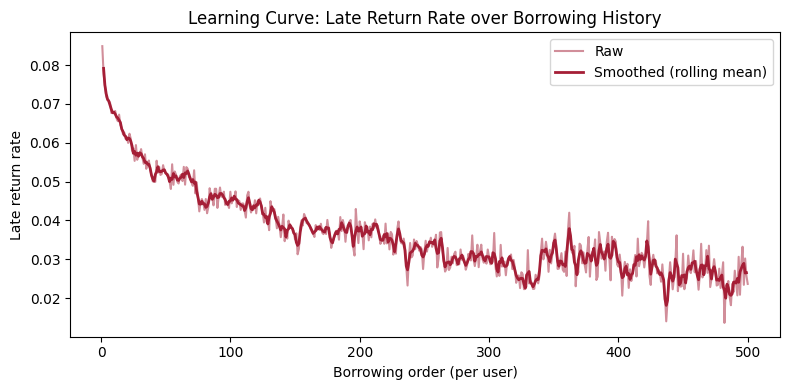

In [246]:
# -- plot learning curve ---

learning_curve["late_rate_smooth"] = (
    learning_curve["late_rate"]
    .rolling(window=3, center=True)
    .mean()
)

plt.figure(figsize=(8, 4))
plt.plot(
    learning_curve["borrow_index"],
    learning_curve["late_rate"],
    alpha=0.5,
    label="Raw"
)
plt.plot(
    learning_curve["borrow_index"],
    learning_curve["late_rate_smooth"],
    linewidth=2,
    label="Smoothed (rolling mean)"
)
plt.xlabel("Borrowing order (per user)")
plt.ylabel("Late return rate")
plt.title("Learning Curve: Late Return Rate over Borrowing History")
plt.legend()
plt.tight_layout()
plt.show()


In [247]:
learning_curve[["borrow_index", "n_obs"]].head(20)
learning_curve[["borrow_index", "n_obs"]].tail(20)

,borrow_index,n_obs
480,481,958
481,482,955
482,483,952
483,484,949
484,485,943
485,486,937
486,487,936
487,488,930
488,489,928
489,490,924


In [248]:
MIN_OBS = 3000

max_index_supported = (
    learning_curve
    .loc[learning_curve["n_obs"] >= MIN_OBS, "borrow_index"]
    .max()
)

max_index_supported


np.int64(209)

In [249]:
df_curve = df_learning[df_learning["borrow_index"] <= max_index_supported].copy()

learning_curve = (
    df_curve
    .groupby("borrow_index")["late_bool"]
    .agg(
        late_rate="mean",
        n_obs="count"
    )
    .reset_index()
)


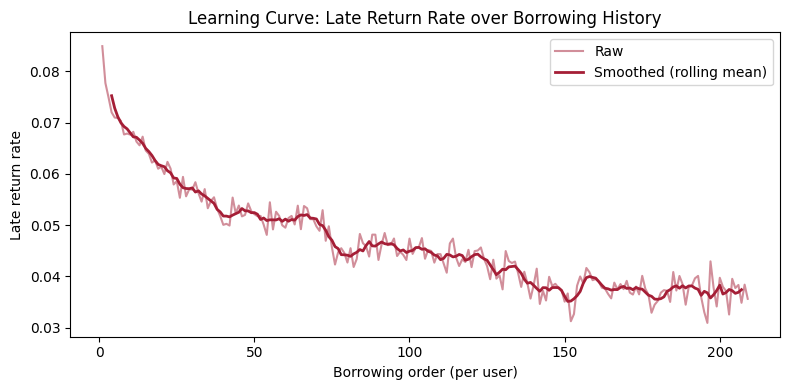

In [253]:
# -- plot learning curve ---

learning_curve["late_rate_smooth"] = (
    learning_curve["late_rate"]
    .rolling(window=6, center=True)
    .mean()
)

plt.figure(figsize=(8, 4))
plt.plot(
    learning_curve["borrow_index"],
    learning_curve["late_rate"],
    alpha=0.5,
    label="Raw"
)
plt.plot(
    learning_curve["borrow_index"],
    learning_curve["late_rate_smooth"],
    linewidth=2,
    label="Smoothed (rolling mean)"
)
plt.xlabel("Borrowing order (per user)")
plt.ylabel("Late return rate")
plt.title("Learning Curve: Late Return Rate over Borrowing History")
plt.legend()
plt.tight_layout()
plt.show()

In [251]:
z = 1.96  # 95% CI

learning_curve["ci_lower"] = (
    learning_curve["late_rate"]
    - z * np.sqrt(
        learning_curve["late_rate"] * (1 - learning_curve["late_rate"])
        / learning_curve["n_obs"]
    )
)

learning_curve["ci_upper"] = (
    learning_curve["late_rate"]
    + z * np.sqrt(
        learning_curve["late_rate"] * (1 - learning_curve["late_rate"])
        / learning_curve["n_obs"]
    )
)



learning_curve["ci_lower"] = learning_curve["ci_lower"].clip(0, 1)
learning_curve["ci_upper"] = learning_curve["ci_upper"].clip(0, 1)


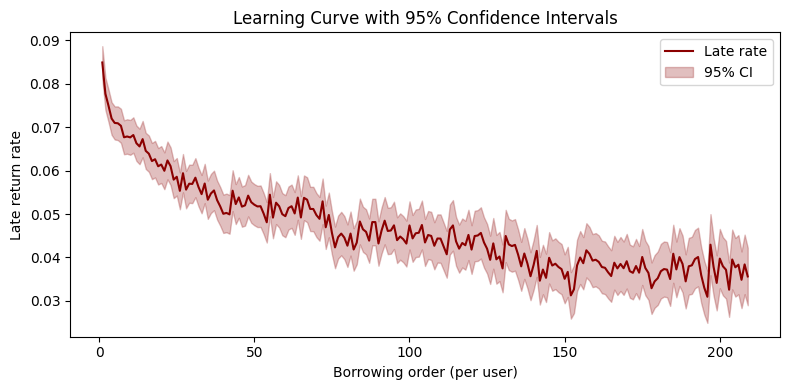

In [252]:
plt.figure(figsize=(8, 4))

plt.plot(
    learning_curve["borrow_index"],
    learning_curve["late_rate"],
    label="Late rate",
    color="darkred"
)

plt.fill_between(
    learning_curve["borrow_index"],
    learning_curve["ci_lower"],
    learning_curve["ci_upper"],
    alpha=0.25,
    label="95% CI",
    color="darkred"
)

plt.xlabel("Borrowing order (per user)")
plt.ylabel("Late return rate")
plt.title("Learning Curve with 95% Confidence Intervals")
plt.legend()
plt.tight_layout()
plt.show()


## Heterogenity: not all users learn the same

## User "types" via behavior profiles

## Does learning differ in User Categories

## Stability of behavior